Column names are ID,  number of peaks,  width of peaks,  NN_length,  NN_width, dimensions,  modus,  best_loss,  best_loss_rel, var_loss,  best_epoch,  best_count,  time,  time_total
Processed 3256 lines.
[2, 4, 8, 16, 32, 2, 4, 8, 16, 32, 2, 4, 8, 16, 32, 2, 4, 8, 16, 32]
[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8]
[20.05016871766141, 29.01846772710132, 37.74958181981662, 1000, 1000, 0.8597553980839228, 0.6709911223385749, 0.31840288434137154, 1000, 1000, 13.784296118631667, 1.3592931622020226, 0.12614138607933334, 1000, 1000, 0, 2.134836914620729, 1.3858726034645392, 0.004931066013085086, 13229.661009478064]
[20.05016871766141, 29.01846772710132, 37.74958181981662, 9, 0.21, 0.8597553980839228, 0.6709911223385749, 0.31840288434137154, 41, 0.0001, 13.784296118631667, 1.3592931622020226, 0.12614138607933334, 0.0077, 0.009, 0, 2.134836914620729, 0.4, 0.0004, 0.0005]
[[2.00501687e+01 2.90184677e+01 3.77495818e+01 9.00000000e+00
  2.10000000e-01]
 [8.59755398e-01 6.70991122

/home/niklas/miniconda3/envs/cs231n/lib/python3.7/site-packages/ipykernel_launcher.py:340: RuntimeWarning: divide by zero encountered in log


"\nimg = ax.imshow(z,extent=[-1,1,-1,1])\n\nx_label_list = ['A2', 'B2', 'C2', 'D2']\n\nax.set_xticks([-0.75,-0.25,0.25,0.75])\n\nax.set_xticklabels(x_label_list)\n\nfig.colorbar(img)\n"

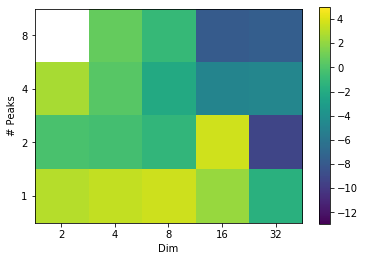

In [62]:
import csv
import numpy as np
import torch
import json
import vegas
from nisrep.normalizing_flows.manager import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict
import math
torch.set_default_dtype(torch.double)

def create_fun(gn, gw):
    
    if(gn==1):
        def f(x):
                return torch.exp(-torch.sum((x-0.5)**2/(gw**2),-1))
        return f
    
    if(gn==2):
        def f(x):
                return torch.exp(-torch.sum((x-0.25)**2/(gw**2),-1))+torch.exp(-torch.sum((x-0.75)**2/(gw**2),-1))
        return f
    
    if(gn==4):
        def f(x):
            shift=torch.ones_like(x)*0.25
            shift1=shift.clone()*3
            lim=int((shift.shape[1]/2))
            shift2=torch.cat((shift[:,:lim],shift1[:,lim:]),-1)
            shift3=torch.cat((shift1[:,:lim],shift[:,lim:]),-1)
            return torch.exp(-torch.sum((x-shift)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift1)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift2)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift3)**2/(gw**2),-1))
        return f
    
    if(gn==8):
        def f(x):
            shift=torch.ones_like(x)*0.25#000
            shift1=shift.clone()*3#111
            lim=int((shift.shape[1]/3))
            shift2=torch.cat((shift[:,:lim],shift1[:,lim:2*lim],shift[:,2*lim:]),-1) #010
            shift3=torch.cat((shift1[:,:lim],shift[:,lim:]),-1)#100
            shift4=torch.cat((shift1[:,:lim],shift1[:,lim:2*lim],shift[:,2*lim:]),-1) #110
            shift5=torch.cat((shift[:,:2*lim],shift1[:,2*lim:]),-1) #001
            shift6=torch.cat((shift1[:,:lim],shift[:,lim:2*lim],shift1[:,2*lim:]),-1) #101
            shift7=torch.cat((shift[:,:lim],shift1[:,lim:]),-1) #011
            return torch.exp(-torch.sum((x-shift)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift1)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift2)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift3)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift4)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift5)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift6)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift7)**2/(gw**2),-1))
        return f
    
def create_funv(gn, gw):
    
    if(gn==1):
        def f(x):
                return np.exp(-np.sum((x-0.5)**2/(gw**2),-1))
        return f # peak at [0.5,...,0.5]
    
    if(gn==2):
        def f(x):
                return np.exp(-np.sum((x-0.25)**2/(gw**2),-1))+np.exp(-np.sum((x-0.75)**2/(gw**2),-1))
        return f  #peak at [0.25,...,0.25] and [0.75,...,0.75]
    
    if(gn==4):
        
        def f(x):
            shift=np.ones_like(x)*0.25
            shift1=shift.copy()*3
            lim=int((shift.shape[0]/2))
            shift2=np.concatenate((shift[:lim],shift1[lim:]),-1)
            shift3=np.concatenate((shift1[:lim],shift[lim:]),-1)
            return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))
        return f #peak at [0.25,...,0.25], [0.75,...,0.75],[0.25,...,0.75], [0.25,...,0.75]
                #in dim2, there would be in the [0,1] plane only two peaks, as two are identical
                # other than gn=2, the [1,2] plane has 4 peaks
              
    
    if(gn==8):
        
        def f(x):
            shift=np.ones_like(x)*0.25#000
            shift1=shift.copy()*3#111
            lim=int(shift.shape[0]/3)
            shift2=np.concatenate((shift[:lim],shift1[lim:2*lim],shift[2*lim:]),0) #010
            shift3=np.concatenate((shift1[:lim],shift[lim:]),0)#100
            shift4=np.concatenate((shift1[:lim],shift1[lim:2*lim],shift[2*lim:]),0) #110
            shift5=np.concatenate((shift[:2*lim],shift1[2*lim:]),0) #001
            shift6=np.concatenate((shift1[:lim],shift[lim:2*lim],shift1[2*lim:]),0) #101
            shift7=np.concatenate((shift[:lim],shift1[lim:]),0) #011
            return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))+ np.exp(-np.sum((x-shift4)**2/(gw**2),-1))+np.exp(-np.sum((x-shift5)**2/(gw**2),-1))+np.exp(-np.sum((x-shift6)**2/(gw**2),-1))+np.exp(-np.sum((x-shift7)**2/(gw**2),-1))
        return f 
    
with open('/home/niklas/Desktop/Thesis_code/Storage_runs/mfrun_full/list_c2', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    lister=[]
    xx=[]
    yy=[]
    zz=[]
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        lister.append(row)
        
    print(f'Processed {line_count} lines.')
    
    for nps in [1,2,4,8]:  
        for wp in [0.15]:
            for dim in [2,4,8,16,32]:
                f=create_fun(nps,wp)
                fv=create_funv(nps,wp)
                w = torch.empty(1000000,dim,requires_grad=False)
                torch.nn.init.uniform_(w)
                f_res=f(w)
                del w
                funcmean_sq=(torch.mean(f_res)**2).numpy() 
                fvar=torch.var(f_res).numpy()
                del f_res
                
                for modus in [' NIS',' VEGAS']:
                    if(modus==" NIS"):
                        minavg=1000
                        minstd=1000
                        min_nnl=0
                        min_nnw=0
                        integavg=0
                        integerr=0
                        meancount=0
                        stdcount=1
                        meancv=0
                        stdcv=0
                        minc=0
                        for nnl in [3,8]:
                            for nnw in [6,11,16]:
                                for c in [int(2*np.ceil(np.log2(dim))), int(4*np.ceil(np.log2(dim)))]:
                                    


                                    x=[v for  v in lister if (int(v[" number of peaks"]) == nps and v[" modus"]==modus and 
                                                              float(v[" width of peaks"]) == wp and int(v["dimensions"])==dim and int(v[" NN_length"])==nnl and int(v[" NN_width"])==nnw)]
                                    ider=(np.array([l["ID"] for l in x]).astype(np.int))
                                    counter=0
                                    for i in range(len(ider)):
                                        with open('/home/niklas/Desktop/Thesis_code/Storage_runs/mfrun_full/NIS/'+str(ider[i])+'/config.json', 'r') as myfile:
                                            data=myfile.read()

                                            obj = json.loads(data)
                                           
                                            
                                            if(obj['n_cells']!=c):
                                                x.remove(x[i-counter])
                                                counter+=1
                                                continue
                                            n_bins=(obj['n_bins'])
                                            
                                        
                                       
                                    ider=(np.array([l["ID"] for l in x]).astype(np.int))
                                    z=(np.array([l[" best_loss"] for l in x]).astype(np.double)-funcmean_sq)/fvar
                                    y=(np.array([l[" best_count"] for l in x]).astype(np.double))
                                    if(len(z)>0):
                                        mean=np.mean(z)
                                        meanc=np.mean(y)
                                        var=np.var(z)
                                        std=np.std(z,ddof=1)/np.sqrt(len(z))
                                        stdc=np.std(y,ddof=1)/np.sqrt(len(z))
                                        """
                                        n_flow=dim
                                        NF =  PWQuadManager(n_flow=n_flow)
                                        NF.create_model(n_cells=c,n_bins=n_bins, NN=[nnw]*nnl,dev=torch.device("cpu"))

                                        integl=[]
                                        errl=[]
                                        for i in range(len(ider)):
                                            try:
                                                model=torch.load('/home/niklas/Desktop/Thesis_code/Storage_runs/mfrun_full/NIS/'+str(ider[i])+'/torch',map_location=torch.device('cpu'))
                                                #print(ider[i])
                                                NF.best_model.load_state_dict(model['model_state_dict'])
                                                w = torch.empty((15000,n_flow)) 
                                                torch.nn.init.uniform_(w,0,1)
                                                Y=NF.format_input(w, dev=torch.device("cpu"))
                                                XZ=NF.best_model(Y)

                                                integl.append(torch.mean(f(XZ[:,:-1])*XZ[:,-1]).tolist())
                                                errl.append((torch.std(f(XZ[:,:-1])*XZ[:,-1])/math.sqrt(15000)).tolist())
                                                del w, Y, XZ
                                            except:
                                                i=i

                                        """

                                        #square added is over the runs!
                                        if(mean<minavg and (z == 1).sum()<=1 and (z==np.nan).sum()<=1 and mean!=np.nan and mean>0):
                                            minavg=mean
                                            minstd=std
                                            min_nnl=nnl
                                            min_nnw=nnw
                                            meancount=meanc
                                            stdcount=stdc
                                            
                                            minc=c
                                            
                                    
                        
                    else:
                      
                        x=[v for  v in lister if (int(v[" number of peaks"]) == nps and v[" modus"]==modus and 
                                                          float(v[" width of peaks"]) == wp and int(v["dimensions"])==dim)]
                       
                        z=(np.array([l[" best_loss"] for l in x]).astype(np.double)-funcmean_sq)/fvar
                        y=(np.array([l[" best_count"] for l in x]).astype(np.double))
                        meancv=np.mean(y)
                       
                        if(len(z)>0):
                            stdcv=np.std(y,ddof=1)/np.sqrt(len(z))
                          
                            meanv=np.mean(z)
                            
                            stdv=np.std(z,ddof=1)/np.sqrt(len(z))
                            integ = vegas.Integrator([[0, 1]]*dim)
                            result=integ(fv, nitn=40, neval=750)
                            
                        
                if(meanv<0 or meanv>1):
                    impratio=minavg
                else:
                    impratio=minavg/meanv
                """
                #print(impratio)
                preprec2=int(np.ceil(np.log10(minavg)))
                if meanv<=0:
                    preprec1=0
                else:
                    preprec1=int(np.ceil(np.log10(meanv)))
                prec2=int(-np.ceil(np.log10(minstd))+2+preprec2)
                prec1=int(-np.ceil(np.log10(stdv))+2+preprec1)
                
                if(meancount<=0):
                    ppreprec2=0
                else:
                    ppreprec2=int(np.ceil(np.log10(meancount)))
                    
                ppreprec1=int(np.ceil(np.log10(meancv)))
                if(stdcount<=0):
                    pprec2=0
                else:
                    pprec2=int(-np.ceil(np.log10(stdcount))+2+ppreprec2)
                if (stdcv<=0):
                    pprec1=0
                else:
                    pprec1=int(-np.ceil(np.log10(stdcv))+2+ppreprec1)
                """
                """
                #print(prec1)
                #print(prec2)
                print("NIS")
                print(integavg)
                print(integerr)
                """
                sdvv=result.sdev/math.sqrt(30000)
               # distance=(np.abs(integavg-result.mean)/(integerr+sdvv))
                #distance=0
                if( not (dim==2 and nps==8)):
                    xx.append(dim)
                    yy.append(nps)
                    zz.append(impratio)
                else:
                    xx.append(dim)
                    yy.append(nps)
                    zz.append(0)
                
                """
                print(integavg)
                print(result.mean)
                print(integerr)
                print(sdvv)
                print(distance)
                """
                """
                if(minavg<1):
                    if(wp<0.3):
                        print("& \\textbf{{{0:.2f}}}    & {6:.3E}     &  {1:.{prec}E} $\\pm$ {2:.2E} &  {7:.{pprec}E} $\\pm$ {8:.2E}    &   {3:.{prec1}E} $\\pm$ {4:.2E}   &   {9:.{pprec1}E} $\\pm$ {10:.2E}& {11:.2E}  &  {5:.3E}  \\\\ \cline{{2-9}}"
                              .format(wp,minavg, minstd, meanv, stdv, impratio, fvar,meancount, stdcount,meancv,stdcv,distance,pprec=pprec2,prec=prec2,prec1=prec1,pprec1=pprec1))
                    else:
                         print("& \\textbf{{{0:.2f}}}    & {6:.3E}       &  {1:.{prec}E} $\\pm$ {2:.2E}   &  {7:.{pprec}E} $\\pm$ {8:.2E}   &   {3:.{prec1}E} $\\pm$ {4:.2E}  &   {9:.{pprec1}E} $\\pm$ {10:.2E}&  {11:.2E}& {5:.3E}   \\\\ \hline"
                               .format(wp,minavg, minstd, meanv, stdv, impratio,fvar,meancount, stdcount,meancv,stdcv,distance,pprec=pprec2, prec=prec2,prec1=prec1,pprec1=pprec1))
                else:
                    if(wp<0.3):
                        print("& \\textbf{{{0:.2f}}}    & {5:.3E}       &  ---  &  ---      &   {3:.{prec1}E} $\\pm$ {4:.2E}  &   {6:.{pprec1}E} $\\pm$ {7:.2E} & ---  & ---     \\\\ \cline{{2-9}}".format(wp,minavg, minstd, meanv, stdv, fvar, meancv,stdcv,prec=prec2,prec1=prec1,pprec1=pprec1))
                    else:
                         print("& \\textbf{{{0:.2f}}}    & {5:.3E}       &  ---  &  ---     &   {3:.{prec1}E} $\\pm$ {4:.2E}  &   {6:.{pprec1}E} $\\pm$ {7:.2E} & ---  & ---     \\\\ \hline".format(wp,minavg, minstd, meanv, stdv,fvar,meancv,stdcv,prec=prec2,prec1=prec1,pprec1=pprec1))
                """

print(zz)
print(np.array(zz).reshape(4,5))

fig, ax = plt.subplots(1,1)

img=ax.imshow(np.flip(np.log(np.array(zz)).reshape(4,5),axis=0), extent=[0,5,0,4],vmin=-13, vmax=5)
x_label_list = ['2', '4', '8', '16' ,'32']

ax.set_xticks([0.5,1.5,2.5,3.5,4.5])

ax.set_xticklabels(x_label_list)
plt.ylabel("# Peaks")


y_label_list = ['1', '2', '4', '8']

ax.set_yticks([0.5,1.5,2.5,3.5])

ax.set_yticklabels(y_label_list)
plt.xlabel("Dim")

fig.colorbar(img)


In [ ]:
& \textbf{0.15}    & 1.100E-06     &  9.29E-03 $\pm$ 2.59E-03 &  1.540E+06 $\pm$ 2.89E+05    &   3.7519E-04 $\pm$ 1.35E-06   &   5E+05 $\pm$ 0.00E+00& 1.54E-01  &  2.477E+01  \\ \cline{2-9}
& \textbf{0.25}    & 9.067E-05     &  7.998E-02 $\pm$ 6.64E-03 &  4.700E+06 $\pm$ 8.72E+05    &   2.4945E-03 $\pm$ 2.04E-05   &   6E+05 $\pm$ 0.00E+00& 1.92E-02  &  3.206E+01  \\ \cline{2-9}
& \textbf{0.35}    & 1.083E-03       &  4.520E-02 $\pm$ 2.32E-03   &  3.614E+07 $\pm$ 8.27E+06   &   4.8832E-03 $\pm$ 9.17E-05  &   8.202E+05 $\pm$ 1.21E+04&  7.76E-01& 9.257E+00   \\ \hline
& \textbf{0.15}    & 2.497E-06     &  5.65E-02 $\pm$ 1.25E-02 &  1.790E+06 $\pm$ 3.23E+05    &   1.774E-01 $\pm$ 1.78E-02   &   8.4146E+05 $\pm$ 7.07E+03& 6.97E-02  &  3.185E-01  \\ \cline{2-9}
& \textbf{0.25}    & 1.530E-04     &  8.767E-02 $\pm$ 4.53E-03 &  3.560E+06 $\pm$ 2.89E+05    &   7.065E-01 $\pm$ 1.66E-02   &   8E+05 $\pm$ 0.00E+00& 5.71E-01  &  1.241E-01  \\ \cline{2-9}
& \textbf{0.35}    & 1.339E-03       &  4.325E-01 $\pm$ 8.43E-02   &  1.790E+06 $\pm$ 4.33E+05   &   9.436E-01 $\pm$ 1.22E-02  &   8E+05 $\pm$ 0.00E+00&  7.10E-01& 4.583E-01   \\ \hline
& \textbf{0.15}    & 6.159E-06     &  1.278E-02 $\pm$ 8.06E-03 &  2.165E+06 $\pm$ 5.15E+05    &   1.0158E-01 $\pm$ 1.71E-03   &   8E+05 $\pm$ 0.00E+00& 4.02E+00  &  1.258E-01  \\ \cline{2-9}
& \textbf{0.25}    & 3.003E-04     &  2.291E-01 $\pm$ 1.48E-02 &  5.040E+06 $\pm$ 5.40E+05    &   6.7335E-01 $\pm$ 7.33E-03   &   8E+05 $\pm$ 0.00E+00& 9.99E-01  &  3.403E-01  \\ \cline{2-9}
& \textbf{0.35}    & 2.526E-03       &  6.89E-01 $\pm$ 1.15E-01   &  7.060E+06 $\pm$ 7.07E+05   &   9.1624E-01 $\pm$ 6.75E-03  &   8E+05 $\pm$ 0.00E+00&  2.07E-01& 7.516E-01   \\ \hline


& \textbf{0.15}    & 1.459E-05     &  1.0729E-01 $\pm$ 2.68E-03 &  3E+06 $\pm$ 0.00E+00    &   7.7358E-02 $\pm$ 9.36E-04   &   8E+05 $\pm$ 0.00E+00& 7.78E-01  &  1.387E+00  \\ \cline{2-9}
& \textbf{0.25}    & 6.044E-04     &  2.699E-01 $\pm$ 2.46E-02 &  5.70E+06 $\pm$ 1.12E+06    &   6.4977E-01 $\pm$ 5.13E-03   &   8E+05 $\pm$ 0.00E+00& 3.67E-02  &  4.154E-01  \\ \cline{2-9}
& \textbf{0.35}    & 5.864E-03       &  9.9629E-01 $\pm$ 3.63E-03   &  4.560E+06 $\pm$ 5.00E+05   &   8.6094E-01 $\pm$ 5.29E-03  &   8E+05 $\pm$ 0.00E+00&  2.05E-01& 1.157E+00   \\ \hline

In [ ]:
& \textbf{0.15}    & 2.819E-13       &  ---  &  ---      &   -1.728230524E-05 $\pm$ 1.31E-08  &   1.1300E+06 $\pm$ 2.75E+04 & ---  & ---     \\ \cline{2-9}
& \textbf{0.25}    & 1.865E-09     &  1.134E-02 $\pm$ 3.06E-03 &  1E+06 $\pm$ 0.00E+00    &   1.17022E-03 $\pm$ 3.65E-06   &   1E+06 $\pm$ 0.00E+00& 3.31E-01  &  9.692E+00  \\ \cline{2-9}
& \textbf{0.35}    & 2.196E-06       &  8.5E-03 $\pm$ 2.90E-02   &  9.60E+06 $\pm$ 2.06E+06   &   1.7355E-03 $\pm$ 1.14E-05  &   1E+06 $\pm$ 0.00E+00&  1.82E+00& 4.878E+00   \\ \hline
& \textbf{0.15}    & 8.002E-15       &  ---  &  ---      &   3.5454E-05 $\pm$ 7.87E-07  &   1E+06 $\pm$ 0.00E+00 & ---  & ---     \\ \cline{2-9}
& \textbf{0.25}    & 1.012E-09     &  3.48E-03 $\pm$ 1.77E-03 &  1.665E+06 $\pm$ 4.73E+05    &   8.451E-05 $\pm$ 1.58E-06   &   1.1127E+06 $\pm$ 2.84E+04& 3.90E-03  &  4.123E+01  \\ \cline{2-9}
& \textbf{0.35}    & 1.220E-06       &  7.49E-02 $\pm$ 3.28E-02   &  1.540E+06 $\pm$ 5.00E+05   &   1.858E+00 $\pm$ 4.12E-01  &   1.1345E+06 $\pm$ 3.75E+04&  4.54E-01& 4.032E-02   \\ \hline
& \textbf{0.15}    & 8.736E-14       &  ---  &  ---      &   -3.2362369E-05 $\pm$ 3.04E-06  &   1E+06 $\pm$ 0.00E+00 & ---  & ---     \\ \cline{2-9}
& \textbf{0.25}    & 7.302E-09     &  7.69E-03 $\pm$ 2.57E-03 &  1E+06 $\pm$ 0.00E+00    &   2.03E+01 $\pm$ 1.99E+01   &   9.818E+05 $\pm$ 9.82E+04& 3.58E-01  &  3.785E-04  \\ \cline{2-9}
& \textbf{0.35}    & 1.711E-06       &  9.82E-02 $\pm$ 9.17E-02   &  4.060E+06 $\pm$ 9.13E+05   &   2.849E+00 $\pm$ 5.30E-01  &   1E+06 $\pm$ 0.00E+00&  6.87E-01& 3.447E-02   \\ \hline
& \textbf{0.15}    & 1.212E-14     &  1.91E-05 $\pm$ 1.11E-05 &  1.290E+06 $\pm$ 1.44E+05    &   6.24E-02 $\pm$ 1.97E-02   &   8.07E+05 $\pm$ 1.21E+05& 5.11E-01  &  3.066E-04  \\ \cline{2-9}
& \textbf{0.25}    & 3.867E-08     &  4.18E-04 $\pm$ 3.98E-04 &  1.165E+06 $\pm$ 1.25E+05    &   2.377E+00 $\pm$ 7.82E-01   &   9.055E+05 $\pm$ 6.55E+04& 2.42E-01  &  1.759E-04  \\ \cline{2-9}
& \textbf{0.35}    & 3.948E-06       &  1.57E-01 $\pm$ 1.73E-01   &  7.96E+06 $\pm$ 1.55E+06   &   1.261E+00 $\pm$ 1.04E-01  &   1E+06 $\pm$ 0.00E+00&  1.30E+00& 1.246E-01   \\ \hline

In [ ]:
& \textbf{0.15}    & 6.239E-55       &  ---  &  ---      &   8.02E+16 $\pm$ 3.62E+16  &   2.206E+05 $\pm$ 2.59E+04 & ---  & ---     \\ \cline{2-9}
& \textbf{0.25}    & 2.092E-20     &  3.10E-04 $\pm$ 2.63E-04 &  1E+06 $\pm$ 0.00E+00    &   1.4285E-03 $\pm$ 7.27E-05   &   2E+06 $\pm$ 0.00E+00& 9.50E-01  &  2.170E-01  \\ \cline{2-9}
& \textbf{0.35}    & 3.046E-11       &  6E-07 $\pm$ 8.88E-05   &  1E+06 $\pm$ 0.00E+00   &   -2.083953246E-04 $\pm$ 6.12E-08  &   2E+06 $\pm$ 0.00E+00&  3.70E-01& -2.765E-03   \\ \hline
& \textbf{0.15}    & 5.349E-64       &  ---  &  ---      &   2.85E+22 $\pm$ 2.14E+22  &   2.376E+05 $\pm$ 3.75E+04 & ---  & ---     \\ \cline{2-9}
& \textbf{0.25}    & 7.459E-27     &  1.28E-04 $\pm$ 2.52E-04 &  1E+06 $\pm$ 0.00E+00    &   1.44E+09 $\pm$ 1.44E+09   &   4.243E+05 $\pm$ 3.79E+04& 3.91E-01  &  8.863E-14  \\ \cline{2-9}
& \textbf{0.35}    & 2.901E-15       &  3.82E-03 $\pm$ 2.74E-03   &  2E+06 $\pm$ 0.00E+00   &   3.67E+00 $\pm$ 3.39E+00  &   1.459E+06 $\pm$ 1.22E+05&  3.80E-01& 1.042E-03   \\ \hline
& \textbf{0.15}    & 1.296E-63       &  ---  &  ---      &   3.90E+18 $\pm$ 3.73E+18  &   3.903E+05 $\pm$ 7.18E+04 & ---  & ---     \\ \cline{2-9}
& \textbf{0.25}    & 1.185E-26     &  8.91E-03 $\pm$ 3.31E-03 &  1E+06 $\pm$ 0.00E+00    &   5.31E+04 $\pm$ 4.38E+04   &   6.11E+05 $\pm$ 1.05E+05& 4.68E-01  &  1.680E-07  \\ \cline{2-9}
& \textbf{0.35}    & 1.441E-12       &  5.39E-05 $\pm$ 3.29E-05   &  1E+06 $\pm$ 0.00E+00   &   1.384E-01 $\pm$ 8.92E-02  &   1.188E+06 $\pm$ 1.58E+05&  1.04E+00& 3.895E-04   \\ \hline
& \textbf{0.15}    & 3.681E-56       &  ---  &  ---      &   8.84E+11 $\pm$ 5.64E+11  &   3.734E+05 $\pm$ 2.26E+04 & ---  & ---     \\ \cline{2-9}
& \textbf{0.25}    & 1.196E-22     &  5.12E-04 $\pm$ 3.07E-04 &  4E+06 $\pm$ 0.00E+00    &   6.58E+00 $\pm$ 3.33E+00   &   7.81E+05 $\pm$ 1.24E+05& 4.98E-01  &  7.772E-05  \\ \cline{2-9}
& \textbf{0.35}    & 5.972E-14       &  1.164E-03 $\pm$ 5.27E-04   &  1E+06 $\pm$ 0.00E+00   &   1.55E+02 $\pm$ 1.30E+02  &   1.358E+06 $\pm$ 1.29E+05&  2.85E-01& 7.534E-06   \\ \hline

Column names are ID,  number of peaks,  width of peaks,  NN_length,  NN_width,  dimensions,  best_loss,  best_loss_rel, var_loss,  best_epoch,  best_count,  time 
Processed 39424 lines.
50
12


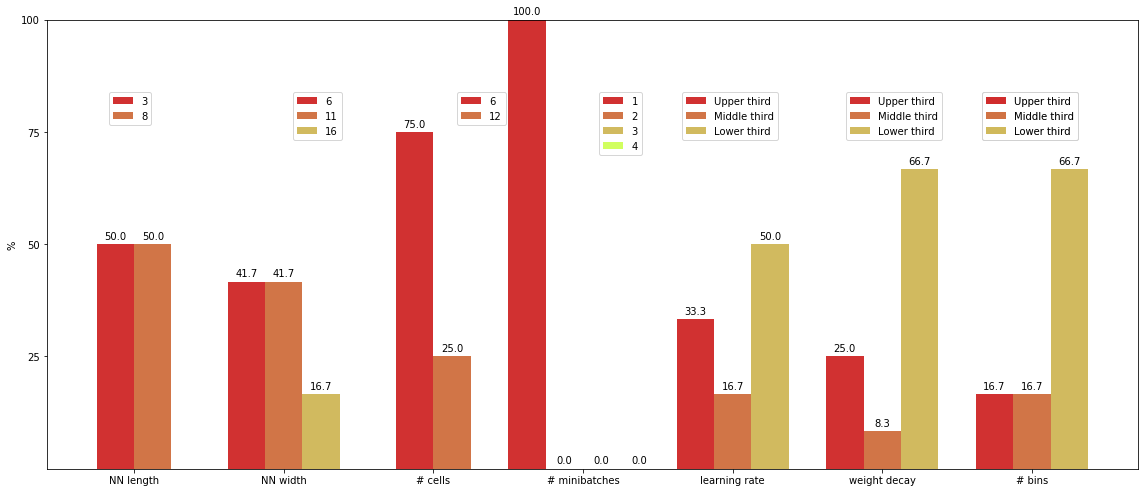

In [282]:
#collect all runs which are within 2 standard deviations of the best 
#-> runtime/gradient descent in dependency of learning rate/runtime
#choose a config for doing this: dim 8, 2 peaks, 0.25
import operator

with open('/home/niklas/Desktop/Thesis_code/Storage_runs/mfrun_full/hypopt/list', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    lister=[]
    xx=[]
    yy=[]
    zz=[]
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        lister.append(row)
        
        line_count += 1
    print(f'Processed {line_count} lines.')
    
    for nps in [2]:  #!!!!
        for wp in [0.25]:
            for dim in [8]:
                
                for modus in [' NIS']:
                    if(modus==" NIS"):
                        minavg=1000
                        minstd=1000
                        min_nnl=0
                        min_nnw=0
                        integavg=0
                        integerr=0
                        meancount=0
                        stdcount=1
                        meancv=0
                        stdcv=0
                        minc=0
                        
                        x=[v for  v in lister if (int(v[" number of peaks"]) == nps and 
                                                              float(v[" width of peaks"]) == wp and int(v[" dimensions"])==dim  and float(v[" best_loss_rel"])<1) ]
                        
                        losses=(np.array([l[" best_loss_rel"] for l in x]).astype(np.double))
                        mean=np.mean(losses)
                        std=np.std(losses,ddof=1)
                        mini=np.min(losses)
                        
                        y=[v for v in x if(float(v[" best_loss_rel"])<2*std+mini)]
                        
                        ider=(np.array([l["ID"] for l in y]).astype(np.int))
                        
                        res=[]
                        
                        for i in range(len(ider)):
                            
                            with open('/home/niklas/Desktop/Thesis_code/Storage_runs/mfrun_full/hypopt/hypopt/'+str(ider[i])+'/config.json', 'r') as myfile:
                                    data=myfile.read()
                                    #print(i)
                                    obj = json.loads(data)

                                    n_bins=(obj['n_bins'])
                                    cells=obj['n_cells']
                                    lr=obj['lr']
                                    wd=obj['weight_decay']
                                    batch=obj['batch_size']
                                    
                                    z=[v for v in y if(float(v["ID"])==ider[i])]
                                   
                                    z[0]['n_bins']=str(n_bins)
                                    z[0]['cells']=str(cells)
                                    z[0]['lr']=str(lr)
                                    z[0]['wd']=str(wd)
                                    z[0]['batch']=str(batch)
                                    
                                    res.append(z[0])
                                    
                        res = np.array(sorted(res, key=lambda k: int(k[' best_epoch'])))
                        print(len(res))
                       
                        res = np.array(sorted(res, key=lambda k: float(k[' time '])))
                        resl=np.array_split(res,4)
                        res_l=resl[0]
                        res=resl[3]
                        print(len(res))
                        
                        
                        lrs=(np.array([l["lr"] for l in res]).astype(np.double))
                        lrsmax=np.max(lrs)
                        lrsmin=np.min(lrs)
                        lrsstep=(lrsmax-lrsmin)/3
                        wds=(np.array([l["wd"] for l in res]).astype(np.double))
                        wdmax=np.max(wds)
                        wdmin=np.min(wds)
                        wdstep=(wdmax-wdmin)/3
                        bins=(np.array([l["n_bins"] for l in res]).astype(np.int))
                        bmax=np.max(bins)
                        bmin=np.min(bins)
                        bstep=(bmax-bmin)/3
                       
                        nnl3=len(np.array( [s for s in res if (int(s[" NN_length"])==3)]))/len(res)
                        
                        nnl8=1-nnl3
                        nnw6=len(np.array( [s for s in res if (int(s[" NN_width"])==6)]))/len(res)
                        nnw11=len(np.array( [s for s in res if (int(s[" NN_width"])==11)]))/len(res)
                        nnw16=len(np.array( [s for s in res if (int(s[" NN_width"])==16)]))/len(res)
                        c6=len(np.array( [s for s in res if (int(s["cells"])==6)]))/len(res)
                        c12=len(np.array( [s for s in res if (int(s["cells"])==12)]))/len(res)
                        b1=len(np.array( [s for s in res if (int(s["batch"])<=40000) and int(s["batch"])>20000]))/len(res)
                        b2=len(np.array( [s for s in res if (int(s["batch"])<=60000)and int(s["batch"])>40000]))/len(res)
                        b3=len(np.array( [s for s in res if (int(s["batch"])<=80000)and int(s["batch"])>60000]))/len(res)
                        b4=len(np.array( [s for s in res if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res)
                        lrsu=len(np.array( [s for s in res if (float(s["lr"])>lrsmin+2*lrsstep)]))/len(res)
                        lrsm=len(np.array( [s for s in res if (float(s["lr"])<=lrsmin+2*lrsstep)and float(s["lr"])>lrsmin+lrsstep]))/len(res)
                        lrsl=len(np.array( [s for s in res if (float(s["lr"])<=lrsmin+lrsstep)]))/len(res)
                        wdu=len(np.array( [s for s in res if (float(s["wd"])>wdmin+2*wdstep)]))/len(res)
                        wdm=len(np.array( [s for s in res if (float(s["wd"])<=wdmin+2*wdstep)and float(s["wd"])>wdmin+wdstep]))/len(res)
                        wdl=len(np.array( [s for s in res if (float(s["wd"])<=wdmin+wdstep)]))/len(res)
                        bu=len(np.array( [s for s in res if (float(s["n_bins"])>bmin+2*bstep)]))/len(res)
                        bm=len(np.array( [s for s in res if (float(s["n_bins"])<=bmin+2*bstep)and float(s["n_bins"])>bmin+bstep]))/len(res)
                        bl=len(np.array( [s for s in res if (float(s["n_bins"])<=bmin+bstep)]))/len(res)
                        
                        
                        
                        
                        labels = ['NN length', 'NN width','# cells' ,'# minibatches', 'learning rate', 'weight decay', '# bins' ]
                        

                        x = np.arange(len(labels))  # the label locations
                        width = 0.25  # the width of the bars
                        co1=(0.8,0.1,0.1,0.9)
                        co2=(0.8,0.4,0.2,0.9)
                        co3=(0.8,0.7,0.3,0.9)
                        co4=(0.8,1,0.3,0.9)

                        fig, ax = plt.subplots()
                        rects1 = ax.bar(x[0] - width/2, nnl3, width,color = co1, label='3')
                        rects2 = ax.bar(x[0] + width/2, nnl8, width,color = co2, label='8')
                        rects3 = ax.bar(x[1] - width, nnw6, width,color = co1, label='6')
                        rects4 = ax.bar(x[1] , nnw11, width,color = co2, label='11')
                        rects5 = ax.bar(x[1] + width, nnw16, width, color=co3,label='16')
                        rects6 = ax.bar(x[2] - width/2, c6, width,color=co1, label='6')
                        rects7 = ax.bar(x[2] + width/2, c12, width, color=co2, label='12')
                        rects8 = ax.bar(x[3] - 3*width/2, b1, width,color=co1, label='1')
                        rects9 = ax.bar(x[3] - width/2, b2, width,color=co2, label='2')
                        rects10 = ax.bar(x[3] + width/2, b3, width, color=co3,label='3')
                        rects11 = ax.bar(x[3] + 3*width/2, b4, width,color=co4, label='4')
                        rects12 = ax.bar(x[4] - width, lrsu, width, color=co1,label='Upper third')
                        rects13 = ax.bar(x[4] , lrsm, width,color=co2, label='Middle third')
                        rects14 = ax.bar(x[4] + width, lrsl, width, color=co3,label='Lower third')
                        rects15 = ax.bar(x[5] - width, wdu, width, color=co1,label='Upper third')
                        rects16 = ax.bar(x[5] , wdm, width, color=co2,label='Middle third')
                        rects17 = ax.bar(x[5] + width, wdl, width, color=co3,label='Lower third')
                        rects18 = ax.bar(x[6] - width, bu, width,color=co1, label='Upper third')
                        rects19 = ax.bar(x[6] , bm, width,color=co2, label='Middle third')
                        rects20 = ax.bar(x[6] + width, bl,width,color=co3,  label='Lower third')

                        # Add some text for labels, title and custom x-axis tick labels, etc.
                        ax.set_ylabel('%')
                        ax.set_ylim([0,1])
                        yl=[25,50,75,100]
                        yt=[0.25,0.5,0.75,1]
                        ax.set_yticks(yt)
                        ax.set_yticklabels(yl)
                        
                        ax.set_xticks(x)
                        ax.set_xticklabels(labels)
                        
                        legend=plt.legend(handles=[rects1,rects2],loc=1, bbox_to_anchor=(0.4*width, 0.85))
                        plt.gca().add_artist(legend)
                        legend=plt.legend(handles=[rects3,rects4,rects5],loc=1, bbox_to_anchor=(1.1*width, 0.85))
                        plt.gca().add_artist(legend)
                        legend=plt.legend(handles=[rects6,rects7],loc=1, bbox_to_anchor=(1.7*width, 0.85))
                        plt.gca().add_artist(legend)
                        legend=plt.legend(handles=[rects8,rects9,rects10,rects11],loc=1, bbox_to_anchor=(2.2*width, 0.85))
                        plt.gca().add_artist(legend)
                        legend=plt.legend(handles=[rects12,rects13,rects14],loc=1, bbox_to_anchor=(2.7*width, 0.85))
                        plt.gca().add_artist(legend)
                        legend=plt.legend(handles=[rects15,rects16,rects17],loc=1, bbox_to_anchor=(3.3*width, 0.85))
                        plt.gca().add_artist(legend)
                        legend=plt.legend(handles=[rects18,rects19,rects20],loc=1, bbox_to_anchor=(3.8*width, 0.85))
                        plt.gca().add_artist(legend)
                        def autolabel(rects):
                            """Attach a text label above each bar in *rects*, displaying its height."""
                            for rect in rects:
                                height = rect.get_height()
                                ax.annotate('{0:.1f}'.format(height*100),
                                            xy=(rect.get_x() + rect.get_width() / 2, height),
                                            xytext=(0, 3),  # 3 points vertical offset
                                            textcoords="offset points",
                                            ha='center', va='bottom')


                        autolabel(rects1)
                        autolabel(rects2)
                        autolabel(rects3)
                        autolabel(rects4)
                        autolabel(rects5)
                        autolabel(rects6)
                        autolabel(rects7)
                        autolabel(rects8)
                        autolabel(rects9)
                        autolabel(rects10)
                        autolabel(rects11)
                        autolabel(rects12)
                        autolabel(rects13)
                        autolabel(rects14)
                        autolabel(rects15)
                        autolabel(rects16)
                        autolabel(rects17)
                        autolabel(rects18)
                        autolabel(rects19)
                        autolabel(rects20)
                        plt.rcParams["figure.figsize"] = (16,8)
                        fig.tight_layout()
                        plt.subplots_adjust(bottom= 0.2, top = 0.98)

                        plt.show()

                        """
                        print("Ratio of NN_len 3: " +str(len(np.array( [s for s in res if (int(s[" NN_length"])==3)]))/len(res)))
                        print("Ratio of NN_len 8: "+ str(len(np.array( [s for s in res if (int(s[" NN_length"])==8)]))/len(res)))
                        print("---")
                        print("Ratio of NN_width 6: "+ str(len(np.array( [s for s in res if (int(s[" NN_width"])==6)]))/len(res)))
                        print("Ratio of NN_width 11: " +str(len(np.array( [s for s in res if (int(s[" NN_width"])==11)]))/len(res)))
                        print("Ratio of NN_width 16: "+ str(len(np.array( [s for s in res if (int(s[" NN_width"])==16)]))/len(res)))
                        print("---")
                        print("Ratio of Cell number 6: "+ str(len(np.array( [s for s in res if (int(s["cells"])==6)]))/len(res)))
                        print("Ratio of Cell number 13: " +str(len(np.array( [s for s in res if (int(s["cells"])==12)]))/len(res)))
                        print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=40000) and int(s["batch"])>20000]))/len(res)))
                        print("Ratio of 2 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=60000)and int(s["batch"])>40000]))/len(res)))
                        print("Ratio of 3 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=80000)and int(s["batch"])>60000]))/len(res)))
                        print("Ratio of 4 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res)))
                        print("---")
                         #print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of upper lrs third: "+ str(len(np.array( [s for s in res if (float(s["lr"])>lrsmin+2*lrsstep)]))/len(res)))
                        print("Ratio of middle lrs third: "+ str(len(np.array( [s for s in res if (float(s["lr"])<=lrsmin+2*lrsstep)and float(s["lr"])>lrsmin+lrsstep]))/len(res)))
                        print("Ratio of lower lrs third: "+ str(len(np.array( [s for s in res if (float(s["lr"])<=lrsmin+lrsstep)]))/len(res)))
                        #print("Ratio of 4 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res)))
                        print("---")
                         #print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of upper wd third: "+ str(len(np.array( [s for s in res if (float(s["wd"])>wdmin+2*wdstep)]))/len(res)))
                        print("Ratio of middle wd third: "+ str(len(np.array( [s for s in res if (float(s["wd"])<=wdmin+2*wdstep)and float(s["wd"])>wdmin+wdstep]))/len(res)))
                        print("Ratio of lower wd third: "+ str(len(np.array( [s for s in res if (float(s["wd"])<=wdmin+wdstep)]))/len(res)))
                        
                        print("---")
                        
                        print("Ratio of upper bin third: "+ str(len(np.array( [s for s in res if (float(s["n_bins"])>bmin+2*bstep)]))/len(res)))
                        print("Ratio of middle bin third: "+ str(len(np.array( [s for s in res if (float(s["n_bins"])<=bmin+2*bstep)and float(s["n_bins"])>bmin+bstep]))/len(res)))
                        print("Ratio of lower bin third: "+ str(len(np.array( [s for s in res if (float(s["n_bins"])<=bmin+bstep)]))/len(res)))
                        #lacking: lr, wd, n_bins
                        print("----------")
                        #HISTOGRAM?
                        res = np.array(sorted(res, key=lambda k: int(k[' best_epoch'])))
                        #print(res)
                        resl=np.split(res,4)
                        res_l=resl[0]
                        res_u=resl[3]
                        print("----------")
                        
                        
                        print("Ratio of NN_len 3: " +str(len(np.array( [s for s in res_l if (int(s[" NN_length"])==3)]))/len(res_l)))
                        print("Ratio of NN_len 8: "+ str(len(np.array( [s for s in res_l if (int(s[" NN_length"])==8)]))/len(res_l)))
                        print("---")
                        print("Ratio of NN_width 6: "+ str(len(np.array( [s for s in res_l if (int(s[" NN_width"])==6)]))/len(res_l)))
                        print("Ratio of NN_width 11: " +str(len(np.array( [s for s in res_l if (int(s[" NN_width"])==11)]))/len(res_l)))
                        print("Ratio of NN_width 16: "+ str(len(np.array( [s for s in res_l if (int(s[" NN_width"])==16)]))/len(res_l)))
                        print("---")
                        print("Ratio of Cell number 6: "+ str(len(np.array( [s for s in res_l if (int(s["cells"])==6)]))/len(res_l)))
                        print("Ratio of Cell number 13: " +str(len(np.array( [s for s in res_l if (int(s["cells"])==12)]))/len(res_l)))
                        print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res_l if (int(s["batch"])<=40000) and int(s["batch"])>20000]))/len(res_l)))
                        print("Ratio of 2 minibatch: "+ str(len(np.array( [s for s in res_l if (int(s["batch"])<=60000)and int(s["batch"])>40000]))/len(res_l)))
                        print("Ratio of 3 minibatch: "+ str(len(np.array( [s for s in res_l if (int(s["batch"])<=80000)and int(s["batch"])>60000]))/len(res_l)))
                        print("Ratio of 4 minibatch: "+ str(len(np.array( [s for s in res_l if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res_l)))
                        print("---")
                         #print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of upper lrs third: "+ str(len(np.array( [s for s in res_l if (float(s["lr"])>lrsmin+2*lrsstep)]))/len(res_l)))
                        print("Ratio of middle lrs third: "+ str(len(np.array( [s for s in res_l if (float(s["lr"])<=lrsmin+2*lrsstep)and float(s["lr"])>lrsmin+lrsstep]))/len(res_l)))
                        print("Ratio of lower lrs third: "+ str(len(np.array( [s for s in res_l if (float(s["lr"])<=lrsmin+lrsstep)]))/len(res_l)))
                        #print("Ratio of 4 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res)))
                        print("---")
                         #print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of upper wd third: "+ str(len(np.array( [s for s in res_l if (float(s["wd"])>wdmin+2*wdstep)]))/len(res_l)))
                        print("Ratio of middle wd third: "+ str(len(np.array( [s for s in res_l if (float(s["wd"])<=wdmin+2*wdstep)and float(s["wd"])>wdmin+wdstep]))/len(res_l)))
                        print("Ratio of lower wd third: "+ str(len(np.array( [s for s in res_l if (float(s["wd"])<=wdmin+wdstep)]))/len(res_l)))
                        
                        print("---")
                        
                        print("Ratio of upper bin third: "+ str(len(np.array( [s for s in res_l if (float(s["n_bins"])>bmin+2*bstep)]))/len(res_l)))
                        print("Ratio of middle bin third: "+ str(len(np.array( [s for s in res_l if (float(s["n_bins"])<=bmin+2*bstep)and float(s["n_bins"])>bmin+bstep]))/len(res_l)))
                        print("Ratio of lower bin third: "+ str(len(np.array( [s for s in res_l if (float(s["n_bins"])<=bmin+bstep)]))/len(res_l)))
                        #lacking: lr, wd, n_bins
                        print("----------")
                        nnl3=len(np.array( [s for s in res_u if (int(s[" NN_length"])==3)]))/len(res_u)
                        nnl8=len(np.array( [s for s in res_u if (int(s[" NN_length"])==8)]))/len(res_u)
                        nnw6=len(np.array( [s for s in res_u if (int(s[" NN_width"])==6)]))/len(res_u)
                        nnw11=len(np.array( [s for s in res_u if (int(s[" NN_width"])==11)]))/len(res_u)
                        nnw16=len(np.array( [s for s in res_u if (int(s[" NN_width"])==16)]))/len(res_u)
                        c6=len(np.array( [s for s in res_u if (int(s["cells"])==6)]))/len(res_u)
                        c12=len(np.array( [s for s in res_u if (int(s["cells"])==12)]))/len(res_u)
                        b1=len(np.array( [s for s in res_u if (int(s["batch"])<=40000) and int(s["batch"])>20000]))/len(res_u)
                        b2=len(np.array( [s for s in res_u if (int(s["batch"])<=60000)and int(s["batch"])>40000]))/len(res_u)
                        b3=len(np.array( [s for s in res_u if (int(s["batch"])<=80000)and int(s["batch"])>60000]))/len(res_u)
                        b4=len(np.array( [s for s in res_u if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res_u)
                        lrsu=len(np.array( [s for s in res_u if (float(s["lr"])>lrsmin+2*lrsstep)]))/len(res_u)
                        lrsm=len(np.array( [s for s in res_u if (float(s["lr"])<=lrsmin+2*lrsstep)and float(s["lr"])>lrsmin+lrsstep]))/len(res_u)
                        lrsl=len(np.array( [s for s in res_u if (float(s["lr"])<=lrsmin+lrsstep)]))/len(res_u)
                        wdu=len(np.array( [s for s in res_u if (float(s["wd"])>wdmin+2*wdstep)]))/len(res_u)
                        wdm=len(np.array( [s for s in res_u if (float(s["wd"])<=wdmin+2*wdstep)and float(s["wd"])>wdmin+wdstep]))/len(res_u)
                        wdl=len(np.array( [s for s in res_u if (float(s["wd"])<=wdmin+wdstep)]))/len(res_u)
                        bu=len(np.array( [s for s in res_u if (float(s["n_bins"])>bmin+2*bstep)]))/len(res_u)
                        bm=len(np.array( [s for s in res_u if (float(s["n_bins"])<=bmin+2*bstep)and float(s["n_bins"])>bmin+bstep]))/len(res_u)
                        bl=len(np.array( [s for s in res_u if (float(s["n_bins"])<=bmin+bstep)]))/len(res_u)
                        
                        print("----------")
                        
                        
                        print("Ratio of NN_len 3: " +str(nnl3))
                        print("Ratio of NN_len 8: "+ str(nnl8))
                        print("---")
                        print("Ratio of NN_width 6: "+ str(nnw6))
                        print("Ratio of NN_width 11: " +str(nnw11))
                        print("Ratio of NN_width 16: "+ str(nnw16))
                        print("---")
                        print("Ratio of Cell number 6: "+ str(c6))
                        print("Ratio of Cell number 13: " +str(c12))
                        print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of 1 minibatch: "+ str(b1))
                        print("Ratio of 2 minibatch: "+ str(b2))
                        print("Ratio of 3 minibatch: "+ str(b3))
                        print("Ratio of 4 minibatch: "+ str(b4))
                        
                        print("---")
                         #print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of upper lrs third: "+ str(lrsu))
                        print("Ratio of middle lrs third: "+ str(lrsm))
                        print("Ratio of lower lrs third: "+ str(lrsl))
                        #print("Ratio of 4 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res)))
                        print("---")
                         #print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of upper wd third: "+ str(wdu))
                        print("Ratio of middle wd third: "+ str(wdm))
                        print("Ratio of lower wd third: "+ str(wdl))
                        
                        print("---")
                        
                        print("Ratio of upper bin third: "+ str(bu))
                        print("Ratio of middle bin third: "+ str(bm))
                        print("Ratio of lower bin third: "+ str(bl))
                         
                        
                        res = np.array(sorted(res, key=lambda k: float(k[' time '])))
                        resl=np.split(res,4)
                        res_l=resl[0]
                        res_u=resl[3]
                        
                        
                        print("----------")
                        print("----------")
                        
                        
                        print("Ratio of NN_len 3: " +str(len(np.array( [s for s in res_l if (int(s[" NN_length"])==3)]))/len(res_l)))
                        print("Ratio of NN_len 8: "+ str(len(np.array( [s for s in res_l if (int(s[" NN_length"])==8)]))/len(res_l)))
                        print("---")
                        print("Ratio of NN_width 6: "+ str(len(np.array( [s for s in res_l if (int(s[" NN_width"])==6)]))/len(res_l)))
                        print("Ratio of NN_width 11: " +str(len(np.array( [s for s in res_l if (int(s[" NN_width"])==11)]))/len(res_l)))
                        print("Ratio of NN_width 16: "+ str(len(np.array( [s for s in res_l if (int(s[" NN_width"])==16)]))/len(res_l)))
                        print("---")
                        print("Ratio of Cell number 6: "+ str(len(np.array( [s for s in res_l if (int(s["cells"])==6)]))/len(res_l)))
                        print("Ratio of Cell number 13: " +str(len(np.array( [s for s in res_l if (int(s["cells"])==12)]))/len(res_l)))
                        print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res_l if (int(s["batch"])<=40000) and int(s["batch"])>20000]))/len(res_l)))
                        print("Ratio of 2 minibatch: "+ str(len(np.array( [s for s in res_l if (int(s["batch"])<=60000)and int(s["batch"])>40000]))/len(res_l)))
                        print("Ratio of 3 minibatch: "+ str(len(np.array( [s for s in res_l if (int(s["batch"])<=80000)and int(s["batch"])>60000]))/len(res_l)))
                        print("Ratio of 4 minibatch: "+ str(len(np.array( [s for s in res_l if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res_l)))
                        print("---")
                         #print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of upper lrs third: "+ str(len(np.array( [s for s in res_l if (float(s["lr"])>lrsmin+2*lrsstep)]))/len(res_l)))
                        print("Ratio of middle lrs third: "+ str(len(np.array( [s for s in res_l if (float(s["lr"])<=lrsmin+2*lrsstep)and float(s["lr"])>lrsmin+lrsstep]))/len(res_l)))
                        print("Ratio of lower lrs third: "+ str(len(np.array( [s for s in res_l if (float(s["lr"])<=lrsmin+lrsstep)]))/len(res_l)))
                        #print("Ratio of 4 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res)))
                        print("---")
                         #print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of upper wd third: "+ str(len(np.array( [s for s in res_l if (float(s["wd"])>wdmin+2*wdstep)]))/len(res_l)))
                        print("Ratio of middle wd third: "+ str(len(np.array( [s for s in res_l if (float(s["wd"])<=wdmin+2*wdstep)and float(s["wd"])>wdmin+wdstep]))/len(res_l)))
                        print("Ratio of lower wd third: "+ str(len(np.array( [s for s in res_l if (float(s["wd"])<=wdmin+wdstep)]))/len(res_l)))
                        
                        print("---")
                        
                        print("Ratio of upper bin third: "+ str(len(np.array( [s for s in res_l if (float(s["n_bins"])>bmin+2*bstep)]))/len(res_l)))
                        print("Ratio of middle bin third: "+ str(len(np.array( [s for s in res_l if (float(s["n_bins"])<=bmin+2*bstep)and float(s["n_bins"])>bmin+bstep]))/len(res_l)))
                        print("Ratio of lower bin third: "+ str(len(np.array( [s for s in res_l if (float(s["n_bins"])<=bmin+bstep)]))/len(res_l)))
                        #lacking: lr, wd, n_bins
                        print("----------")
                        nnl3=len(np.array( [s for s in res_u if (int(s[" NN_length"])==3)]))/len(res_u)
                        nnl8=len(np.array( [s for s in res_u if (int(s[" NN_length"])==8)]))/len(res_u)
                        nnw6=len(np.array( [s for s in res_u if (int(s[" NN_width"])==6)]))/len(res_u)
                        nnw11=len(np.array( [s for s in res_u if (int(s[" NN_width"])==11)]))/len(res_u)
                        nnw16=len(np.array( [s for s in res_u if (int(s[" NN_width"])==16)]))/len(res_u)
                        c6=len(np.array( [s for s in res_u if (int(s["cells"])==6)]))/len(res_u)
                        c12=len(np.array( [s for s in res_u if (int(s["cells"])==12)]))/len(res_u)
                        b1=len(np.array( [s for s in res_u if (int(s["batch"])<=40000) and int(s["batch"])>20000]))/len(res_u)
                        b2=len(np.array( [s for s in res_u if (int(s["batch"])<=60000)and int(s["batch"])>40000]))/len(res_u)
                        b3=len(np.array( [s for s in res_u if (int(s["batch"])<=80000)and int(s["batch"])>60000]))/len(res_u)
                        b4=len(np.array( [s for s in res_u if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res_u)
                        lrsu=len(np.array( [s for s in res_u if (float(s["lr"])>lrsmin+2*lrsstep)]))/len(res_u)
                        lrsm=len(np.array( [s for s in res_u if (float(s["lr"])<=lrsmin+2*lrsstep)and float(s["lr"])>lrsmin+lrsstep]))/len(res_u)
                        lrsl=len(np.array( [s for s in res_u if (float(s["lr"])<=lrsmin+lrsstep)]))/len(res_u)
                        wdu=len(np.array( [s for s in res_u if (float(s["wd"])>wdmin+2*wdstep)]))/len(res_u)
                        wdm=len(np.array( [s for s in res_u if (float(s["wd"])<=wdmin+2*wdstep)and float(s["wd"])>wdmin+wdstep]))/len(res_u)
                        wdl=len(np.array( [s for s in res_u if (float(s["wd"])<=wdmin+wdstep)]))/len(res_u)
                        bu=len(np.array( [s for s in res_u if (float(s["n_bins"])>bmin+2*bstep)]))/len(res_u)
                        bm=len(np.array( [s for s in res_u if (float(s["n_bins"])<=bmin+2*bstep)and float(s["n_bins"])>bmin+bstep]))/len(res_u)
                        bl=len(np.array( [s for s in res_u if (float(s["n_bins"])<=bmin+bstep)]))/len(res_u)
                        
                        print("----------")
                        
                        
                        print("Ratio of NN_len 3: " +str(nnl3))
                        print("Ratio of NN_len 8: "+ str(nnl8))
                        print("---")
                        print("Ratio of NN_width 6: "+ str(nnw6))
                        print("Ratio of NN_width 11: " +str(nnw11))
                        print("Ratio of NN_width 16: "+ str(nnw16))
                        print("---")
                        print("Ratio of Cell number 6: "+ str(c6))
                        print("Ratio of Cell number 13: " +str(c12))
                        print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of 1 minibatch: "+ str(b1))
                        print("Ratio of 2 minibatch: "+ str(b2))
                        print("Ratio of 3 minibatch: "+ str(b3))
                        print("Ratio of 4 minibatch: "+ str(b4))
                        
                        print("---")
                         #print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of upper lrs third: "+ str(lrsu))
                        print("Ratio of middle lrs third: "+ str(lrsm))
                        print("Ratio of lower lrs third: "+ str(lrsl))
                        #print("Ratio of 4 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=100000)and int(s["batch"])>80000]))/len(res)))
                        print("---")
                         #print("---")
                        #print("Ratio of 1 minibatch: "+ str(len(np.array( [s for s in res if (int(s["batch"])<=20000)]))/len(res)))
                        print("Ratio of upper wd third: "+ str(wdu))
                        print("Ratio of middle wd third: "+ str(wdm))
                        print("Ratio of lower wd third: "+ str(wdl))
                        
                        print("---")
                        
                        print("Ratio of upper bin third: "+ str(bu))
                        print("Ratio of middle bin third: "+ str(bm))
                        print("Ratio of lower bin third: "+ str(bl))
                         
                        """
                        
                        
                        
                        #print("best_loss_rel, NN_length, NN_width, cells, bins, lr, wd, best_epoch")
                      
                        #for i in range(len(res)):
                        #    x=res[i]
                        #    print(str(x[" best_loss_rel"])+", "+x[" NN_length"]+", "+x[" NN_width"]+", "+
                        #          x["cells"]+", "+x["n_bins"]+", "+x["lr"]+", "+x["wd"]+", "+x[" best_epoch"]+"\n")
                            
                        """    
                        res.sort(key=operator.itemgetter(' time '),reverse=True)
                        print("best_loss_rel, NN_length, NN_width, cells, bins, lr, wd, time")
                        for i in range(len(res)):
                            x=res[i]
                            print(str(x[" best_loss_rel"])+", "+x[" NN_length"]+", "+x[" NN_width"]+", "+
                                  x["cells"]+", "+x["n_bins"]+", "+x["lr"]+", "+x["wd"]+", "+x[" time "]+"\n")
                        """
                        #how to evaluate the data
                        #order for grad steps -> look at lr/archi
                        # same again with runtime
                        #look at range for parameters
                        i=i
                        #"""
                        """
                        for nnl in [3,8]:
                            for nnw in [6,11,16]:
                                for c in [int(2*np.ceil(np.log2(dim))), int(4*np.ceil(np.log2(dim)))]:
                                    


                                    x=[v for  v in lister if (int(v[" number of peaks"]) == nps and v[" modus"]==modus and 
                                                              float(v[" width of peaks"]) == wp and int(v["dimensions"])==dim and int(v[" NN_length"])==nnl and int(v[" NN_width"])==nnw)]
                                    ider=(np.array([l["ID"] for l in x]).astype(np.int))
                                    counter=0
                                    for i in range(len(ider)):
                                        with open('/home/niklas/Desktop/Thesis_code/Storage_runs/mfrun_full/NIS/'+str(ider[i])+'/config.json', 'r') as myfile:
                                            data=myfile.read()

                                            obj = json.loads(data)
                                           
                                            
                                            if(obj['n_cells']!=c):
                                                x.remove(x[i-counter])
                                                counter+=1
                                                continue
                                            n_bins=(obj['n_bins'])
                                            
                                        
                                       
                                    ider=(np.array([l["ID"] for l in x]).astype(np.int))
                                    z=(np.array([l[" best_loss"] for l in x]).astype(np.double)-funcmean_sq)/fvar
                                    y=(np.array([l[" best_count"] for l in x]).astype(np.double))
                                    if(len(z)>0):
                                        mean=np.mean(z)
                                        meanc=np.mean(y)
                                        var=np.var(z)
                                        std=np.std(z,ddof=1)/np.sqrt(len(z))
                                        stdc=np.std(y,ddof=1)/np.sqrt(len(z))
                                    """
        
        
      

In [295]:
for dim in [2,4,8,16,32]: 
    for nps in [1,2,4,8]:  #!!!!
        for wp in [0.15,0.25,0.35]:
            
                f=create_fun(nps,wp)
                
                w = torch.empty(1000000,dim,requires_grad=False)
                torch.nn.init.uniform_(w)
                f_res=f(w)
               
                funcmean=(torch.mean(f_res)).numpy() 
                fvar=(torch.var(f_res)/funcmean).numpy()
                
                print("Original variance for {0:d} peaks with width {1:2f} in dim {3:d}: {2:.3E}".format(nps,wp,fvar,dim))
               

Original variance for 1 peaks with width 0.150000 in dim 2: 4.303E-01
Original variance for 1 peaks with width 0.250000 in dim 2: 3.103E-01
Original variance for 1 peaks with width 0.350000 in dim 2: 1.894E-01
Original variance for 2 peaks with width 0.150000 in dim 2: 3.702E-01
Original variance for 2 peaks with width 0.250000 in dim 2: 2.401E-01
Original variance for 2 peaks with width 0.350000 in dim 2: 1.447E-01
Original variance for 4 peaks with width 0.150000 in dim 2: 2.348E-01
Original variance for 4 peaks with width 0.250000 in dim 2: 6.242E-02
Original variance for 4 peaks with width 0.350000 in dim 2: 6.530E-02
Original variance for 8 peaks with width 0.150000 in dim 2: 1.483E+00
Original variance for 8 peaks with width 0.250000 in dim 2: 9.602E-01
Original variance for 8 peaks with width 0.350000 in dim 2: 5.797E-01
Original variance for 1 peaks with width 0.150000 in dim 4: 2.442E-01
Original variance for 1 peaks with width 0.250000 in dim 4: 2.163E-01
Original variance fo